<a href="https://colab.research.google.com/github/lianealbarghouthi/projects/blob/main/Stack_Exchange_Useful_Question_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
train_html = pd.read_csv('stack_stats_2020_train.csv')
test_html = pd.read_csv('stack_stats_2020_test.csv')

In [3]:
train_html.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19247 entries, 0 to 19246
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      19247 non-null  int64 
 1   Score   19247 non-null  int64 
 2   Body    19247 non-null  object
 3   Title   19247 non-null  object
 4   Tags    19247 non-null  object
dtypes: int64(2), object(3)
memory usage: 752.0+ KB


In [4]:
test_html.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8249 entries, 0 to 8248
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      8249 non-null   int64 
 1   Score   8249 non-null   int64 
 2   Body    8249 non-null   object
 3   Title   8249 non-null   object
 4   Tags    8249 non-null   object
dtypes: int64(2), object(3)
memory usage: 322.4+ KB


For the purposes of part a of this assignment, I am concatenating the datasets so that we can
perform basic text cleaning and DTM on them with relative ease.

In [5]:
df = pd.concat([train_html, test_html])
df.head()

,Id,Score,Body,Title,Tags
0,495560,1,<p>I have a set of data that I am transforming...,R: emmeans back tranform clr data using clrInv,<r><mixed-model><linear><lsmeans>
1,489896,0,<p>We are sending a one bit message to someone...,Trying to determine the failure rate of redund...,<probability><python>
2,497951,2,<p>I am aware that there is a similar post: <a...,How to derive categorical cross entropy update...,<logistic><cross-entropy>
3,478542,2,<p>I have a Poisson distributed glm where I ha...,"Learning more about glm parameters, how to dig...",<generalized-linear-model><interpretation>
4,458388,0,<p>1) how do i decide which transformation or ...,Is there I guide to decide which transformatio...,<python><data-transformation><dataset><feature...


In [6]:
df['1_or_higher'] = pd.Series([1 if x >= 1 else 0 for x in df['Score']], index=df.index)
df.head()

,Id,Score,Body,Title,Tags,1_or_higher
0,495560,1,<p>I have a set of data that I am transforming...,R: emmeans back tranform clr data using clrInv,<r><mixed-model><linear><lsmeans>,1
1,489896,0,<p>We are sending a one bit message to someone...,Trying to determine the failure rate of redund...,<probability><python>,0
2,497951,2,<p>I am aware that there is a similar post: <a...,How to derive categorical cross entropy update...,<logistic><cross-entropy>,1
3,478542,2,<p>I have a Poisson distributed glm where I ha...,"Learning more about glm parameters, how to dig...",<generalized-linear-model><interpretation>,1
4,458388,0,<p>1) how do i decide which transformation or ...,Is there I guide to decide which transformatio...,<python><data-transformation><dataset><feature...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27496 entries, 0 to 8248
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           27496 non-null  int64 
 1   Score        27496 non-null  int64 
 2   Body         27496 non-null  object
 3   Title        27496 non-null  object
 4   Tags         27496 non-null  object
 5   1_or_higher  27496 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


In [8]:
from bs4 import BeautifulSoup

In [9]:
def clean_text(df, body, title, tags):
  joined_body, joined_title, joined_tags = [], [], []
  for entry in df[body]:
    entry = BeautifulSoup(entry).get_text()
    entry = entry.split()
    lst_body = []
    for string in entry:
      lst_body.append(string.replace('\n', ''))
    joined = '--'.join(lst_body)
    joined = ' '.join(lst_body)
    joined_body.append(joined)

  for entry in df[title]:
    entry = BeautifulSoup(entry).get_text()
    entry = entry.split()
    lst_title = []
    for string in entry:
      lst_title.append(string.replace('\n', ''))
    joined = '--'.join(lst_title)
    joined = ' '.join(lst_title)
    joined_title.append(joined)
  for entry in df[tags]:
    entry = entry.replace('<', ' ')
    entry = entry.replace('>', ' ')
    joined_tags.append(entry)

  new_df = pd.DataFrame({'Body': joined_body, 'Title' : joined_title, 'Tags':joined_tags})
  return new_df

In [10]:
cleaned_df = clean_text(df, 'Body', 'Title', 'Tags')
cleaned_df.head()

,Body,Title,Tags
0,I have a set of data that I am transforming us...,R: emmeans back tranform clr data using clrInv,r mixed-model linear lsmeans
1,We are sending a one bit message to someone. T...,Trying to determine the failure rate of redund...,probability python
2,I am aware that there is a similar post: Vecto...,How to derive categorical cross entropy update...,logistic cross-entropy
3,I have a Poisson distributed glm where I have ...,"Learning more about glm parameters, how to dig...",generalized-linear-model interpretation
4,1) how do i decide which transformation or sca...,Is there I guide to decide which transformatio...,python data-transformation dataset feature...


In [11]:
cleaned_df['Body'] = cleaned_df['Body'].str.lower()
cleaned_df['Title'] = cleaned_df['Title'].str.lower()
cleaned_df['Tags'] = cleaned_df['Tags'].str.lower()
cleaned_df.head()

,Body,Title,Tags
0,i have a set of data that i am transforming us...,r: emmeans back tranform clr data using clrinv,r mixed-model linear lsmeans
1,we are sending a one bit message to someone. t...,trying to determine the failure rate of redund...,probability python
2,i am aware that there is a similar post: vecto...,how to derive categorical cross entropy update...,logistic cross-entropy
3,i have a poisson distributed glm where i have ...,"learning more about glm parameters, how to dig...",generalized-linear-model interpretation
4,1) how do i decide which transformation or sca...,is there i guide to decide which transformatio...,python data-transformation dataset feature...


In [12]:
from string import punctuation
def remove_punctuation(document):
  no_punct = ''.join([character for character in document if character not in punctuation])
  return no_punct

In [13]:
cleaned_df['Body'] = cleaned_df['Body'].apply(remove_punctuation)
cleaned_df['Title'] = cleaned_df['Title'].apply(remove_punctuation)
cleaned_df['Tags'] = cleaned_df['Tags'].apply(remove_punctuation)
cleaned_df.head()

,Body,Title,Tags
0,i have a set of data that i am transforming us...,r emmeans back tranform clr data using clrinv,r mixedmodel linear lsmeans
1,we are sending a one bit message to someone th...,trying to determine the failure rate of redund...,probability python
2,i am aware that there is a similar post vector...,how to derive categorical cross entropy update...,logistic crossentropy
3,i have a poisson distributed glm where i have ...,learning more about glm parameters how to dig ...,generalizedlinearmodel interpretation
4,1 how do i decide which transformation or scal...,is there i guide to decide which transformatio...,python datatransformation dataset featuree...


In [14]:
def remove_digit(document):
  no_digit = ''.join([character for character in document if not character.isdigit()])
  return no_digit

In [15]:
cleaned_df['Body'] = cleaned_df['Body'].apply(remove_digit)
cleaned_df['Title'] = cleaned_df['Title'].apply(remove_digit)
cleaned_df['Tags'] = cleaned_df['Tags'].apply(remove_digit)
cleaned_df.head()

,Body,Title,Tags
0,i have a set of data that i am transforming us...,r emmeans back tranform clr data using clrinv,r mixedmodel linear lsmeans
1,we are sending a one bit message to someone th...,trying to determine the failure rate of redund...,probability python
2,i am aware that there is a similar post vector...,how to derive categorical cross entropy update...,logistic crossentropy
3,i have a poisson distributed glm where i have ...,learning more about glm parameters how to dig ...,generalizedlinearmodel interpretation
4,how do i decide which transformation or scali...,is there i guide to decide which transformatio...,python datatransformation dataset featuree...


In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
from nltk.tokenize import word_tokenize
df_body_tokenized = cleaned_df['Body'].apply(word_tokenize)
df_title_tokenized = cleaned_df['Title'].apply(word_tokenize)
df_tags_tokenized = cleaned_df['Tags'].apply(word_tokenize)
df_body_tokenized.head()

0    [i, have, a, set, of, data, that, i, am, trans...
1    [we, are, sending, a, one, bit, message, to, s...
2    [i, am, aware, that, there, is, a, similar, po...
3    [i, have, a, poisson, distributed, glm, where,...
4    [how, do, i, decide, which, transformation, or...
Name: Body, dtype: object

In [18]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(document):
  words = [word for word in document if not word in stop_words]
  return words
df_body_remove_stopwords = df_body_tokenized.apply(remove_stopwords)
df_title_remove_stopwords = df_title_tokenized.apply(remove_stopwords)
df_tags_remove_stopwords = df_tags_tokenized.apply(remove_stopwords)
df_body_remove_stopwords.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [set, data, transforming, using, clr, function...
1    [sending, one, bit, message, someone, chance, ...
2    [aware, similar, post, vectorization, cross, e...
3    [poisson, distributed, glm, identified, origin...
4    [decide, transformation, scaling, use, passing...
Name: Body, dtype: object

In [19]:
#stemming
from nltk.stem import PorterStemmer
porter = PorterStemmer()
def stemmer(document):
  stemmed_document = [porter.stem(word) for word in document]
  return stemmed_document
df_body_stem = df_body_remove_stopwords.apply(stemmer)
df_title_stem = df_title_remove_stopwords.apply(stemmer)
df_tags_stem = df_tags_remove_stopwords.apply(stemmer)
df_body_stem.head()

0    [set, data, transform, use, clr, function, lib...
1    [send, one, bit, messag, someon, chanc, messag...
2    [awar, similar, post, vector, cross, entropi, ...
3    [poisson, distribut, glm, identifi, origin, pa...
4    [decid, transform, scale, use, pass, data, mac...
Name: Body, dtype: object

In [20]:
#detokenization
from nltk.tokenize.treebank import TreebankWordDetokenizer
df_body_detokenize = df_body_stem.apply(TreebankWordDetokenizer().detokenize)
df_title_detokenize = df_title_stem.apply(TreebankWordDetokenizer().detokenize)
df_tags_detokenize = df_tags_stem.apply(TreebankWordDetokenizer().detokenize)
df_body_detokenize.head()

0    set data transform use clr function librarycom...
1    send one bit messag someon chanc messag bit tr...
2    awar similar post vector cross entropi loss lo...
3    poisson distribut glm identifi origin paramet ...
4    decid transform scale use pass data machin lea...
Name: Body, dtype: object

In [21]:
#document-term matrix
from sklearn.feature_extraction.text import CountVectorizer
countvec_body = CountVectorizer(min_df = 0.01)
countvec_title = CountVectorizer(min_df = 0.01)
countvec_tags = CountVectorizer(min_df = 0.01)
sparse_dtm_body = countvec_body.fit_transform(df_body_detokenize)
sparse_dtm_title = countvec_title.fit_transform(df_title_detokenize)
sparse_dtm_tags = countvec_tags.fit_transform(df_tags_detokenize)
sparse_dtm_body

<27496x903 sparse matrix of type '<class 'numpy.int64'>'
	with 1040543 stored elements in Compressed Sparse Row format>

In [22]:
dtm_body = pd.DataFrame(sparse_dtm_body.toarray(), columns=countvec_body.get_feature_names(), index=cleaned_df.index)
dtm_body.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ab,abl,absolut,accept,accord,account,accur,accuraci,achiev,across,activ,actual,ad,add,addit,adjust,advanc,advic,affect,age,aic,aim,al,algorithm,allow,almost,along,alpha,alreadi,also,altern,although,alway,among,amount,analys,analysi,analyz,anoth,anova,...,variou,vector,version,via,view,visual,vs,want,way,week,weight,well,what,wherea,whether,whole,whose,wikipedia,within,without,wonder,word,work,would,wouldnt,write,written,wrong,xi,xn,xt,xx,xy,ye,year,yet,yi,yield,yt,zero
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
dtm_title = pd.DataFrame(sparse_dtm_title.toarray(), columns=countvec_title.get_feature_names(), index=cleaned_df.index)
dtm_title.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,algorithm,analysi,anova,base,bayesian,best,binari,binomi,calcul,categor,chang,classif,cluster,coeffici,compar,comput,condit,confid,continu,correct,correl,covari,data,dataset,depend,determin,differ,distribut,effect,error,estim,expect,factor,featur,find,fit,forecast,function,gaussian,gener,...,plot,point,poisson,predict,predictor,probabl,problem,process,question,random,ratio,regress,residu,result,sampl,scale,score,select,seri,set,signific,size,squar,standard,statist,term,test,time,train,transform,two,understand,use,valid,valu,variabl,varianc,vs,way,weight
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [24]:
dtm_tags = pd.DataFrame(sparse_dtm_tags.toarray(), columns=countvec_tags.get_feature_names(), index=cleaned_df.index)
dtm_tags.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,anova,arima,bayesian,categoricaldata,causal,chisquaredtest,classif,cluster,conditionalprob,confidenceinterv,correl,crossvalid,dataset,datatransform,distribut,econometr,estim,expectedvalu,featureselect,forecast,generalizedlinearmodel,hypothesistest,infer,interact,interpret,leastsquar,linearmodel,lmenlm,logist,machinelearn,mathematicalstatist,maximumlikelihood,mean,mixedmodel,model,multilevelanalysi,multipleregress,multivariateanalysi,neuralnetwork,normaldistribut,optim,paneldata,pca,predictivemodel,probabl,pvalu,python,randomforest,randomvari,regress,regressioncoeffici,repeatedmeasur,sampl,scikitlearn,selfstudi,statisticalsignific,surviv,timeseri,ttest,varianc
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
body_frequencies = dtm_body.sum().sort_values(ascending=False)
print(body_frequencies[body_frequencies > 50])

model        31442
use          29753
data         27090
variabl      19379
would        16504
             ...  
aim            295
suspect        294
latter         291
mistak         288
similarli      288
Length: 903, dtype: int64


In [26]:
title_frequencies = dtm_title.sum().sort_values(ascending=False)
print(title_frequencies[title_frequencies > 50])

model         4142
regress       2947
use           2713
variabl       2554
data          2549
              ... 
neg            292
understand     291
point          290
residu         286
poisson        284
Length: 109, dtype: int64


In [27]:
tags_frequencies = dtm_tags.sum().sort_values(ascending=False)
print(tags_frequencies[tags_frequencies > 50])

regress                   3887
machinelearn              3031
timeseri                  1839
probabl                   1679
neuralnetwork             1458
hypothesistest            1310
mathematicalstatist       1221
distribut                 1199
bayesian                  1122
mixedmodel                1030
python                     992
logist                     980
classif                    882
statisticalsignific        831
normaldistribut            774
multipleregress            763
correl                     755
selfstudi                  744
generalizedlinearmodel     673
anova                      671
confidenceinterv           595
varianc                    587
sampl                      570
lmenlm                     554
model                      554
infer                      540
estim                      496
crossvalid                 484
forecast                   484
cluster                    442
maximumlikelihood          441
ttest                      439
pca     

In [28]:
dtm_body = dtm_body.add_suffix('_body')
dtm_body.head()

,ab_body,abl_body,absolut_body,accept_body,accord_body,account_body,accur_body,accuraci_body,achiev_body,across_body,activ_body,actual_body,ad_body,add_body,addit_body,adjust_body,advanc_body,advic_body,affect_body,age_body,aic_body,aim_body,al_body,algorithm_body,allow_body,almost_body,along_body,alpha_body,alreadi_body,also_body,altern_body,although_body,alway_body,among_body,amount_body,analys_body,analysi_body,analyz_body,anoth_body,anova_body,...,variou_body,vector_body,version_body,via_body,view_body,visual_body,vs_body,want_body,way_body,week_body,weight_body,well_body,what_body,wherea_body,whether_body,whole_body,whose_body,wikipedia_body,within_body,without_body,wonder_body,word_body,work_body,would_body,wouldnt_body,write_body,written_body,wrong_body,xi_body,xn_body,xt_body,xx_body,xy_body,ye_body,year_body,yet_body,yi_body,yield_body,yt_body,zero_body
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
dtm_title = dtm_title.add_suffix('_title')
dtm_title.head()

,algorithm_title,analysi_title,anova_title,base_title,bayesian_title,best_title,binari_title,binomi_title,calcul_title,categor_title,chang_title,classif_title,cluster_title,coeffici_title,compar_title,comput_title,condit_title,confid_title,continu_title,correct_title,correl_title,covari_title,data_title,dataset_title,depend_title,determin_title,differ_title,distribut_title,effect_title,error_title,estim_title,expect_title,factor_title,featur_title,find_title,fit_title,forecast_title,function_title,gaussian_title,gener_title,...,plot_title,point_title,poisson_title,predict_title,predictor_title,probabl_title,problem_title,process_title,question_title,random_title,ratio_title,regress_title,residu_title,result_title,sampl_title,scale_title,score_title,select_title,seri_title,set_title,signific_title,size_title,squar_title,standard_title,statist_title,term_title,test_title,time_title,train_title,transform_title,two_title,understand_title,use_title,valid_title,valu_title,variabl_title,varianc_title,vs_title,way_title,weight_title
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [30]:
dtm_tags = dtm_tags.add_suffix('_tags')
dtm_tags.head()

,anova_tags,arima_tags,bayesian_tags,categoricaldata_tags,causal_tags,chisquaredtest_tags,classif_tags,cluster_tags,conditionalprob_tags,confidenceinterv_tags,correl_tags,crossvalid_tags,dataset_tags,datatransform_tags,distribut_tags,econometr_tags,estim_tags,expectedvalu_tags,featureselect_tags,forecast_tags,generalizedlinearmodel_tags,hypothesistest_tags,infer_tags,interact_tags,interpret_tags,leastsquar_tags,linearmodel_tags,lmenlm_tags,logist_tags,machinelearn_tags,mathematicalstatist_tags,maximumlikelihood_tags,mean_tags,mixedmodel_tags,model_tags,multilevelanalysi_tags,multipleregress_tags,multivariateanalysi_tags,neuralnetwork_tags,normaldistribut_tags,optim_tags,paneldata_tags,pca_tags,predictivemodel_tags,probabl_tags,pvalu_tags,python_tags,randomforest_tags,randomvari_tags,regress_tags,regressioncoeffici_tags,repeatedmeasur_tags,sampl_tags,scikitlearn_tags,selfstudi_tags,statisticalsignific_tags,surviv_tags,timeseri_tags,ttest_tags,varianc_tags
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
merge_dtm = pd.merge(dtm_body, dtm_title, left_index=True, right_index=True)
merge_dtm.head()

,ab_body,abl_body,absolut_body,accept_body,accord_body,account_body,accur_body,accuraci_body,achiev_body,across_body,activ_body,actual_body,ad_body,add_body,addit_body,adjust_body,advanc_body,advic_body,affect_body,age_body,aic_body,aim_body,al_body,algorithm_body,allow_body,almost_body,along_body,alpha_body,alreadi_body,also_body,altern_body,although_body,alway_body,among_body,amount_body,analys_body,analysi_body,analyz_body,anoth_body,anova_body,...,plot_title,point_title,poisson_title,predict_title,predictor_title,probabl_title,problem_title,process_title,question_title,random_title,ratio_title,regress_title,residu_title,result_title,sampl_title,scale_title,score_title,select_title,seri_title,set_title,signific_title,size_title,squar_title,standard_title,statist_title,term_title,test_title,time_title,train_title,transform_title,two_title,understand_title,use_title,valid_title,valu_title,variabl_title,varianc_title,vs_title,way_title,weight_title
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [32]:
combined_dtm = pd.merge(merge_dtm, dtm_tags, left_index=True, right_index=True)
combined_dtm.head()

,ab_body,abl_body,absolut_body,accept_body,accord_body,account_body,accur_body,accuraci_body,achiev_body,across_body,activ_body,actual_body,ad_body,add_body,addit_body,adjust_body,advanc_body,advic_body,affect_body,age_body,aic_body,aim_body,al_body,algorithm_body,allow_body,almost_body,along_body,alpha_body,alreadi_body,also_body,altern_body,although_body,alway_body,among_body,amount_body,analys_body,analysi_body,analyz_body,anoth_body,anova_body,...,generalizedlinearmodel_tags,hypothesistest_tags,infer_tags,interact_tags,interpret_tags,leastsquar_tags,linearmodel_tags,lmenlm_tags,logist_tags,machinelearn_tags,mathematicalstatist_tags,maximumlikelihood_tags,mean_tags,mixedmodel_tags,model_tags,multilevelanalysi_tags,multipleregress_tags,multivariateanalysi_tags,neuralnetwork_tags,normaldistribut_tags,optim_tags,paneldata_tags,pca_tags,predictivemodel_tags,probabl_tags,pvalu_tags,python_tags,randomforest_tags,randomvari_tags,regress_tags,regressioncoeffici_tags,repeatedmeasur_tags,sampl_tags,scikitlearn_tags,selfstudi_tags,statisticalsignific_tags,surviv_tags,timeseri_tags,ttest_tags,varianc_tags
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
combined_dtm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27496 entries, 0 to 27495
Columns: 1072 entries, ab_body to varianc_tags
dtypes: int64(1072)
memory usage: 224.9 MB


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

First, I’m going to split the dataframe df back into the original train and test set data based on the
indices obtained at the beginning of this notebook. The indices correspond to where the original
training data starts and ends and where the original test data starts and ends.

In [35]:
train = combined_dtm.loc[0:19246]
test = combined_dtm.loc[19247:]

For the logistic regression and classification tree models, we want to look at binary categorical
variables in this case. Since a useful question is any question with a score greater than or equal
to one, I added a new variable called ‘1_or_higher’ at the very beginning of the notebook, and I
am showing this in the cell below. Here, a 1 corresponds to a useful question that has an original
score greater than or equal to one, and a 0 corresponds to a useless question with a score of 0 or a
negative score.

In [36]:
df['1_or_higher'].iloc[19247:]

0       0
1       0
2       1
3       1
4       1
       ..
8244    0
8245    1
8246    1
8247    1
8248    1
Name: 1_or_higher, Length: 8249, dtype: int64

In [37]:
print(df['Score'].iloc[0:19246].value_counts())
print(df['Score'].iloc[19247:].value_counts())

 0     9597
 1     5291
 2     2123
 3      968
 4      515
 5      235
 6      133
 7       83
-1       66
 8       57
 9       40
 11      15
-2       14
 10      13
 12      12
 15       9
 14       8
 13       8
 18       7
-3        6
 24       5
 17       5
 29       3
 20       3
 30       3
 22       3
 25       2
 37       2
 27       2
 26       2
 23       2
 16       2
 53       2
 33       1
 49       1
 36       1
 34       1
 51       1
 21       1
 60       1
 38       1
 41       1
 54       1
Name: Score, dtype: int64
 0     4177
 1     2271
 2      913
 3      399
 4      168
 5       93
 6       64
-1       42
 7       37
 8       16
 10      12
 9       11
 13       7
-2        7
 17       4
 14       4
 15       3
 11       3
 20       2
 12       2
 16       1
 32       1
 24       1
 57       1
 23       1
 18       1
 26       1
 34       1
 43       1
 21       1
 77       1
 22       1
 30       1
 19       1
Name: Score, dtype: int64


I first assessed our baseline model. The majority of scores in the ‘Score’ column are shown to be
0 above in both in the training and test set, so for our baseline, I will set the values to 0 and see
what the accuracy looks like.

In [38]:
y_pred_baseline = pd.Series([0 for x in df['Score']], index=df['Score'].index)
cm_baseline = confusion_matrix(df['Score'], y_pred_baseline)
print ("Baseline Confusion Matrix : \n", cm_baseline)
print ("\nBaseline Accuracy:", accuracy_score(df['Score'], y_pred_baseline))

Baseline Confusion Matrix : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Baseline Accuracy: 0.5009819610125109


Next, I’m going to look at a logistic regression model. For this model, I am using the ‘1_or_higher’
variable I defined above. Again, a 1 refers to a useful question, and a 0 refers to a useless question.

In [39]:
from sklearn.linear_model import LogisticRegression
X_train_log = train
X_test_log = test
y_train_log = df['1_or_higher'].iloc[:19247]
y_test_log =df['1_or_higher'].iloc[19247:]
logreg = LogisticRegression(random_state=88)
logreg.fit(X_train_log, y_train_log)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=88)

In [40]:
y_prob_log = logreg.predict_proba(X_test_log)
y_pred_log = pd.Series([1 if x > 0.5 else 0 for x in y_prob_log[:,1]],index=y_test_log.index)
cm_log = confusion_matrix(y_test_log, y_pred_log)
print ("Logistic Regression Confusion Matrix: \n", cm_log)
print ("\n Logistic Regression Accuracy:", accuracy_score(y_test_log,y_pred_log))
print ("\nLogistic Regression TPR:", recall_score(y_test_log, y_pred_log))

Logistic Regression Confusion Matrix: 
 [[2578 1648]
 [1896 2127]]

 Logistic Regression Accuracy: 0.5703721663231907

Logistic Regression TPR: 0.5287099179716629


Next, I will construct two LDA models. The first model predicts the ‘Score’ variable. The second
model predicts the ‘1_or_higher’ binary classification variable I defined above.

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train = train
X_test = test
y_train = df['Score'].iloc[:19247]
y_test = df['Score'].iloc[19247:]
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [42]:
y_pred_lda = lda.predict(X_test)
cm_lda = confusion_matrix(y_test, y_pred_lda)
print ("LDA Confusion Matrix: \n", cm_lda)
print ("\n LDA Accuracy:", accuracy_score(y_test, y_pred_lda))

LDA Confusion Matrix: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

 LDA Accuracy: 0.44963025821311675


In [43]:
lda_binary = LinearDiscriminantAnalysis()
lda_binary.fit(X_train, y_train_log)

LinearDiscriminantAnalysis()

In [44]:
y_pred_lda_binary = lda_binary.predict(X_test)
cm_lda_binary = confusion_matrix(y_test_log, y_pred_lda_binary)
print ("Binary Classification LDA Confusion Matrix: \n", cm_lda_binary)
print ("\n Binary Classification LDA Accuracy:", accuracy_score(y_test_log,y_pred_lda_binary))
print ("\nBinary Classification LDA TPR:", recall_score(y_test_log,y_pred_lda_binary))

Binary Classification LDA Confusion Matrix: 
 [[2571 1655]
 [1944 2079]]

 Binary Classification LDA Accuracy: 0.5637046914777549

Binary Classification LDA TPR: 0.5167785234899329


Next, I will construct two Random Forest models. The first model predicts the ‘Score’ variable.
The second model predicts the ‘1_or_higher’ binary classification variable I defined above.

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features=5, min_samples_leaf=5,n_estimators=500, random_state=88)
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=5, min_samples_leaf=5, n_estimators=500,
                       random_state=88)

In [46]:
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print ("RF Confusion Matrix: \n", cm_rf)
print ("\n RF Accuracy:", accuracy_score(y_test, y_pred_rf))

RF Confusion Matrix: 
 [[   0    0    7 ...    0    0    0]
 [   0    0   42 ...    0    0    0]
 [   0    0 4177 ...    0    0    0]
 ...
 [   0    0    1 ...    0    0    0]
 [   0    0    1 ...    0    0    0]
 [   0    0    1 ...    0    0    0]]

 RF Accuracy: 0.5063644078070069


In [47]:
rf_binary = RandomForestClassifier(max_features=5, min_samples_leaf=5,n_estimators=500, random_state=88)
rf_binary.fit(X_train, y_train_log)

RandomForestClassifier(max_features=5, min_samples_leaf=5, n_estimators=500,
                       random_state=88)

In [48]:
y_pred_rf_binary = rf_binary.predict(X_test)
cm_rf_binary = confusion_matrix(y_test_log, y_pred_rf_binary)
print ("Binary Classification RF Confusion Matrix: \n", cm_rf_binary)
print ("\n Binary Classification RF Accuracy:", accuracy_score(y_test,y_pred_rf_binary))
print ("\nBinary Classification RF TPR:", recall_score(y_test_log,y_pred_rf_binary))

Binary Classification RF Confusion Matrix: 
 [[2646 1580]
 [1869 2154]]

 Binary Classification RF Accuracy: 0.4461146805673415

Binary Classification RF TPR: 0.5354213273676361


In [49]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train_log)
y_pred_gbc = gbc.predict(X_test)

In [50]:
cm_gbc = confusion_matrix(y_test_log, y_pred_gbc)
print ("Boosting Confusion Matrix: \n", cm_gbc)
print ("Boosting Accuracy:", accuracy_score(y_test_log, y_pred_gbc))
print ("DTC TPR:", recall_score(y_test_log, y_pred_gbc))

Boosting Confusion Matrix: 
 [[2941 1285]
 [2187 1836]]
Boosting Accuracy: 0.579100497029943
DTC TPR: 0.4563758389261745


In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train_log)

DecisionTreeClassifier()

In [52]:
y_pred_dtc = dtc.predict(X_test)
y_pred_dtc

array([0, 0, 0, ..., 1, 1, 1])

In [53]:
cm_dtc = confusion_matrix(y_test, y_pred_dtc)
print ("DTC Confusion Matrix: \n", cm_dtc)
print ("DTC Accuracy:", accuracy_score(y_test_log, y_pred_dtc))
print ("DTC TPR:", recall_score(y_test_log, y_pred_dtc))

DTC Confusion Matrix: 
 [[   0    0    3 ...    0    0    0]
 [   0    0   26 ...    0    0    0]
 [   0    0 2114 ...    0    0    0]
 ...
 [   0    0    1 ...    0    0    0]
 [   0    0    1 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
DTC Accuracy: 0.5095163050066674
DTC TPR: 0.5120556798409147


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201)}
dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [55]:
y_pred_dtr = dtr.predict(X_test)
y_pred_dtr

array([0., 0., 0., ..., 0., 0., 0.])

In [56]:
cm_dtr = confusion_matrix(y_test, y_pred_dtr)
print ("DTR Confusion Matrix: \n", cm_dtr)
print ("DTR Accuracy:", accuracy_score(y_test, y_pred_dtr))

DTR Confusion Matrix: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
DTR Accuracy: 0.36610498242211176


As we can see above, our boosting model had the highest accuracy at 0.579. The logisitic regression
model had the second highest accuracy at approximately 0.570, and the binary classification LDA
model had the third highest accuracy at approximately 0.564. That being said, the boosting model’s
TPR was the lowest of these three models at 0.456. The logistic regression model had the highest
TPR at approximately 0.528. The binary classification LDA model had a TPR of around 0.517.
Given this information, I would say that the logistic regression model is the most promising on
this dataset given its combination of a high accuracy and high TPR relative to the other models I
constructed above. Based on this assessment, I will construct a bootstrap of the logistic regression
model.
Some other notes on the models constructed above is that the decision tree regressor had the lowest
accuracy at 0.369. This is likely because with this dataset, it is a lot more difficult to accurately
predict exact continuous scores rather than a binary outcome/classification. I think that for this
reason, the decision tree classifier performed better on the test set with an accuracy of 0.517 and
a TPR of 0.520. The fact that all of our independent variables are categorical is perhaps another
factor to this.

In [57]:
def accuracy_func(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  acc = accuracy_score(y_test, y_pred)
  return acc

In [58]:
def bootstrap_validation(test_data, test_label, train_label, y_pred, model,metrics_list, sample=500, random_state=66):
  import time
  tic = time.time()
  n_sample = sample
  n_metrics = len(metrics_list)
  output_array=np.zeros([n_sample, n_metrics])
  output_array[:]=np.nan
  print(output_array.shape)
  for bs_iter in range(n_sample):
    bs_index = np.random.choice(test_data.index, len(test_data.index),replace=True)
    bs_data = test_data.loc[bs_index]
    bs_label = test_label.loc[bs_index]
    bs_predicted = model.predict(bs_data)
    for metrics_iter in range(n_metrics):
      metrics = metrics_list[metrics_iter]
      output_array[bs_iter, metrics_iter]=metrics(bs_label,bs_predicted) -  metrics(test_label, y_pred)
      if bs_iter % 100 == 0:
        print(bs_iter, time.time()-tic)
  output_df = pd.DataFrame(output_array)
  return output_df

In [59]:
X_test['new_index'] = np.arange(0, 8249)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
X_test['new_index']

19247       0
19248       1
19249       2
19250       3
19251       4
         ... 
27491    8244
27492    8245
27493    8246
27494    8247
27495    8248
Name: new_index, Length: 8249, dtype: int64

In [61]:
X_test_new = X_test.set_index('new_index')

In [62]:
logreg_bs = bootstrap_validation(X_test_new, y_test_log, y_train_log,y_pred_log, logreg, [accuracy_func])
logreg_bs

(500, 1)
0 0.12029123306274414
100 11.442304134368896
200 22.737414121627808
300 34.01444101333618
400 45.15598917007446


,0
0,-0.005819
1,0.004243
2,-0.007031
3,0.001333
4,0.005940
...,...
495,0.004243
496,0.013092
497,0.000849
498,0.002182


(array([ 1.,  2.,  3.,  5., 15., 13., 35., 40., 48., 61., 66., 62., 54.,
        46., 25., 11.,  5.,  6.,  1.,  1.]),
 array([-0.46211662, -0.46035883, -0.45860104, -0.45684325, -0.45508546,
        -0.45332768, -0.45156989, -0.4498121 , -0.44805431, -0.44629652,
        -0.44453873, -0.44278094, -0.44102315, -0.43926537, -0.43750758,
        -0.43574979, -0.433992  , -0.43223421, -0.43047642, -0.42871863,
        -0.42696084]),
 <a list of 20 Patch objects>)

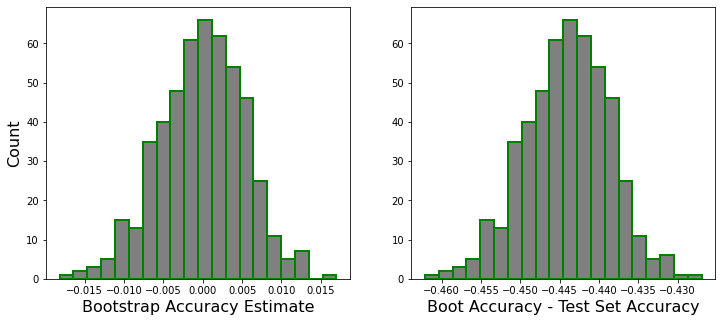

In [63]:
test_accuracy_logreg = accuracy_func(y_test,y_pred_log)
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap Accuracy Estimate', fontsize=16)
axs[1].set_xlabel('Boot Accuracy - Test Set Accuracy', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(logreg_bs.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color ="grey")
axs[1].hist(logreg_bs.iloc[:,0]-test_accuracy_logreg,bins=20,edgecolor='green', linewidth=2,color = "grey")

In [64]:
# The 95% confidence interval
CI_logreg = np.quantile(logreg_bs.iloc[:,0]-test_accuracy_logreg,np.array([0.025,0.975]))
CI_logreg[0] = test_accuracy_logreg - CI_logreg[1]
CI_logreg[1] = test_accuracy_logreg - CI_logreg[0]
print("The 95-percent confidence interval of accuracy is %s" % CI_logreg)

The 95-percent confidence interval of accuracy is [ 0.87791247 -0.43397988]


Accuracy gives us the proportion of the correctly classified data points over all of the data points.
The TPR tells us the proportion of data points correctly classified to be positive over all of the
positive data points. In this case, ‘positive’ refers to useful scores – i.e. scores greater than or
equal to one. To maximize the probability that the top question is useful, I think we would be
more interested in knowing the accuracy of our model. Regardless of whether our model uses
binary classification (like logistic regression) or multi-classification (like one of the CART models
we used), the accuracy would tell us how likely it is that our model would predict the correct score,
which in turn is a metric for how useful a question is. The higher the accuracy of our model, the
better it is at predicting useful questions (scores >= 1) versus questions with scores less than one.
However, I would also consider looking at the TPR in conjunction to the accuracy as another way
of choosing an optimal model. For example, if we had two models with very similar/close accuracies but varying TPRs, it would make more sense to choose the model with the higher TPR in this
case.

Based on the models I constructed, I would say that the logistic regression model comes the closest
to accomplishing the goal outlined in part i of this question. The logistic regression model I built
had one of the highest accuracies (by a very small margin to the boosting model’s accuracy), and it
also had the highest TPR, whereas the boosting model had a relatively high accuracy but relatively
low TPR.
Due to its combination of high accuracy and high TPR (relative to the dataset we used and the
models I constructed), I would say that the logistic regression model maximizes the probability that
useful questions are correctly identified/classified, and would thus help improve Stack Exchange’s
current method by more accurately predicting which of the 15 most recent questions are useful.
This would help Stack Exchange adjust the order in which these 15 questions appear to the user.
Since the logistic regression model had an accuracy of around 0.57, this means that there is a
probability of 0.57 that a question is correctly classified to be useful (score >= 1) or not useful. If
Stack Exchange displays most recent results or even randomizes the most recent results, we don’t
have the exact probabilities for how likely it is that the top question is useful. If we use the logistic
regression model, our liklihood increases, and our model can predict with a probability of 0.57 that
questions are correctly classified. Thus, there is a probability of around 0.57 that the top question
is correctly classified to be a useful question.